**Final Implementation:**
Super Resolution using ESRGAN

Importing Modules

In [2]:
import os
import time
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Add, Concatenate, LeakyReLU, Conv2D, Lambda, UpSampling2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [10]:
tf.executing_eagerly()

True

In [12]:
! pip install -q kaggle

In [13]:
from google.colab import files

files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"eknoorsingh","key":"edb4b72b89cd6dfd11b3f9db6410ab83"}'}

In [20]:
! chmod 600 /content/gdrive/MyDrive/Kaggle/kaggle.json

In [21]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              234KB  2021-07-18 10:41:46           9358  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5735  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2074  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2430  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [22]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [23]:
!kaggle datasets download -d bansalyash/div2k-hr

100% 3.29G/3.29G [00:57<00:00, 29.7MB/s]
100% 3.29G/3.29G [00:58<00:00, 60.9MB/s]


In [24]:
!unzip \*.zip  && rm *.zip

Archive:  div2k-hr.zip
  inflating: DIV2K_train_HR/0001.png  
  inflating: DIV2K_train_HR/0002.png  
  inflating: DIV2K_train_HR/0003.png  
  inflating: DIV2K_train_HR/0004.png  
  inflating: DIV2K_train_HR/0005.png  
  inflating: DIV2K_train_HR/0006.png  
  inflating: DIV2K_train_HR/0007.png  
  inflating: DIV2K_train_HR/0008.png  
  inflating: DIV2K_train_HR/0009.png  
  inflating: DIV2K_train_HR/0010.png  
  inflating: DIV2K_train_HR/0011.png  
  inflating: DIV2K_train_HR/0012.png  
  inflating: DIV2K_train_HR/0013.png  
  inflating: DIV2K_train_HR/0014.png  
  inflating: DIV2K_train_HR/0015.png  
  inflating: DIV2K_train_HR/0016.png  
  inflating: DIV2K_train_HR/0017.png  
  inflating: DIV2K_train_HR/0018.png  
  inflating: DIV2K_train_HR/0019.png  
  inflating: DIV2K_train_HR/0020.png  
  inflating: DIV2K_train_HR/0021.png  
  inflating: DIV2K_train_HR/0022.png  
  inflating: DIV2K_train_HR/0023.png  
  inflating: DIV2K_train_HR/0024.png  
  inflating: DIV2K_train_HR/0025.png  
  

**Image Processing **

In [25]:
PATH = '/content/gdrive/MyDrive/Kaggle/DIV2K_train_HR'
EPOCHS = 4

def random_crop(input_image):
    start_height = np.random.randint(0,input_image.shape[0]-96)
    start_width = np.random.randint(0,input_image.shape[1]-96)
    image = input_image[start_height:start_height+96 , start_width:start_width+96]
    return image

def load_hr(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)
    image = np.asarray(image)
    hr_image = random_crop(image)
    return hr_image

def load_lr(hr_image):
    lr_image = cv2.resize(hr_image, (24,24))
    return lr_image

def normalize(image):
    image_t = tf.convert_to_tensor(image , dtype = tf.float32)
    image_t = image_t/127.5 -1
    return image_t


train_dataset = os.listdir(PATH)
for i in range(len(train_dataset)):
  train_dataset[i] = PATH + '/'+train_dataset[i]
train_hr_dataset = list(map(load_hr, train_dataset))
train_lr_dataset = list(map(load_lr,train_hr_dataset))
train_hr_dataset = tf.convert_to_tensor(list(map(normalize , train_hr_dataset)))
train_lr_dataset = tf.convert_to_tensor(list(map(normalize , train_lr_dataset)))

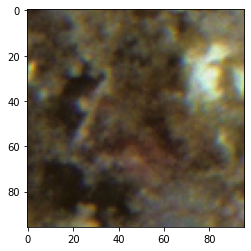

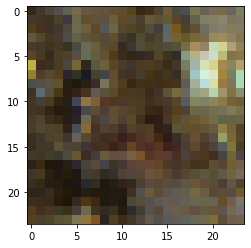

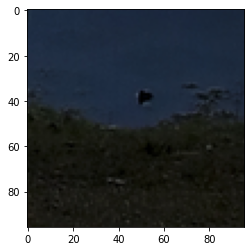

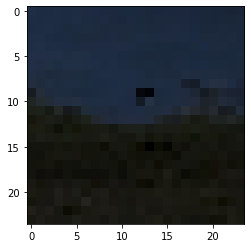

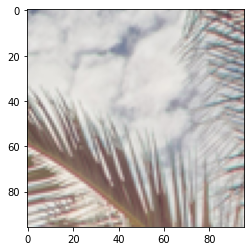

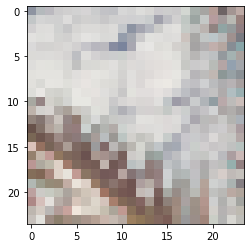

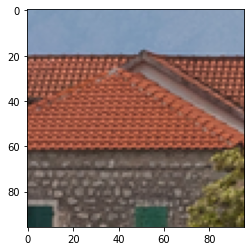

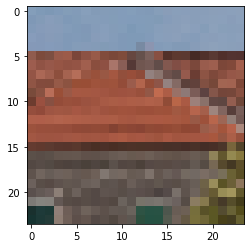

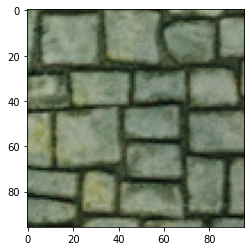

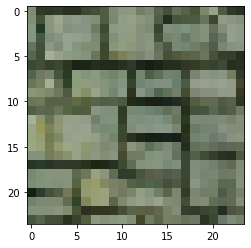

In [27]:
#shows the processed images
for i in range(5):
    plt.imshow(train_hr_dataset[i]/2 + 0.5)
    plt.show()
    plt.imshow(train_lr_dataset[i]/2 + 0.5)
    plt.show()

In [28]:
#Generator

In [29]:
def dense_block(inpt):
    b1 = Conv2D(64, kernel_size=3, strides=1, padding='same')(inpt)
    b1 = LeakyReLU(0.2)(b1)
    b1 = Concatenate()([inpt,b1])
    b2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(b1)
    b2 = LeakyReLU(0.2)(b2)
    b2 = Concatenate()([inpt,b1,b2]) 
    b5 = Conv2D(64, kernel_size=3, strides=1, padding='same')(b2)
    b5 = b5*0.2
    b5 = Add()([b5, inpt])
    return b5

def RRDB(inpt):
    x = dense_block(inpt)
    x = dense_block(x)
    x = x*0.2
    out = Add()([x,inpt])

    return out

def buildGenerator():
  inpt = tf.keras.Input(shape = [24,24,3])
  up = UpSampling2D(4)(inpt)
  conv1 =Conv2D(64 , kernel_size = 3 , strides = 1,padding = 'same')(up)
  rrdb = RRDB(conv1)
  conv = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same',activation = 'relu')(rrdb)
  out = Conv2D(3 , kernel_size= 3 , strides = 1 , padding = 'same')(conv)
  return tf.keras.Model(inputs = inpt , outputs = out)

In [30]:
generator = buildGenerator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
up_sampling2d (UpSampling2D)    (None, 96, 96, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 64)   1792        up_sampling2d[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 64)   36928       conv2d[0][0]                     
______________________________________________________________________________________________

In [31]:
#DISCRIMINATOR

In [32]:
from keras import backend as K
def build_discriminator():
    
    
    leakyrelu_alpha = 0.2
    momentum = 0.8

    input_0 = tf.keras.layers.Input(shape=(24,24,3))
    input_0_upscale = UpSampling2D(4)(input_0)

    input_1 = tf.keras.layers.Input(shape=(96,96,3))
    input_2 = tf.keras.layers.Input(shape = (96,96,3))

    x = tf.keras.layers.concatenate([input_0_upscale,input_1])
    y = tf.keras.layers.concatenate([input_0_upscale,input_2])
    for i in range(4):
      x = Conv2D(64 , kernel_size = 6 , strides = 1 , padding = 'same')(x)
      y = Conv2D(64 , kernel_size = 6 , strides = 1 , padding = 'same')(y)
      x = LeakyReLU()(x)
      y = LeakyReLU()(y)
      x = tf.keras.layers.BatchNormalization()(x)
      y = tf.keras.layers.BatchNormalization()(y)

    logits = x-K.mean(y)
    # fully connected layer 
    output = Conv2D(1,4, activation='sigmoid' , padding = 'same')(logits)   
    
    model = tf.keras.Model(inputs=[input_0 , input_1,input_2], outputs=[output], name='discriminator')
    
    return model

In [33]:
discriminator = build_discriminator()
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 96, 96, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
______________________________________________________________________________________

***ESRGAN Building***

In [34]:
#relativistic loss
def relativistic_loss(disc_real,disc_gen):
    real = disc_real
    fake = disc_gen
    fake_logits = K.sigmoid(fake - K.mean(real))
    real_logits = K.sigmoid(real - K.mean(fake))
            
    return [fake_logits, real_logits]

In [35]:
def discriminator_loss(fake_logits , real_logits) :
  return  K.mean(K.binary_crossentropy(K.zeros_like(fake_logits),fake_logits)+K.binary_crossentropy(K.ones_like(real_logits),real_logits))

def generator_loss(fake_logits , real_logits) :
  return  K.mean(K.binary_crossentropy(K.zeros_like(real_logits),real_logits)+K.binary_crossentropy(K.ones_like(fake_logits),fake_logits))

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# The VGG model for VGG loss , made for our input shape 
vgg = VGG19(include_top = False, input_shape=(96,96,3))

Lambda = 0.05
Eeta = 1 #both these values are supposed to be changed after epochs. The initial values are such that the GAN first predicts a rough figure about the images
EPOCHS = 50


def train_step(input_lr_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_lr_image, training=True)

        real_logits  = discriminator([input_lr_image, target , gen_output], training=True)
        fake_logits  = discriminator([input_lr_image, target , gen_output], training=True)
        gen_loss     = Lambda*generator_loss(fake_logits, real_logits)
        gen_loss    += Eeta*tf.reduce_mean(tf.abs(target - gen_output))
        feature_gen  = vgg(preprocess_input(gen_output))
        feature_real = vgg(preprocess_input(np.copy(target)))
        vgg_loss     = tf.keras.losses.mean_squared_error(feature_gen , feature_real)
        gen_loss    += 100*vgg_loss
        disc_loss = discriminator_loss(fake_logits, real_logits)

    generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
def fit(train_lr,train_hr, epochs):
    for epoch in range(epochs):
        start = time.time()
        print(".")
        for i in range(150):
          input_image  = train_lr[4*i:4*i+4]
          target  =  train_hr[4*i:4*i+4]
          train_step(input_image,target , epoch)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        generated = generator(train_lr_dataset[0:5])
        for i in range(len(generated)):
          plt.subplot(1,3,1)
          plt.imshow(train_lr_dataset[i]/2+0.5)
          plt.subplot(1,3,2)
          plt.imshow(train_hr_dataset[i]/2+0.5)
          plt.subplot(1,3,3)
          plt.imshow(generated[i]/2 + 0.5)
          plt.show()


        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
        



checkpoint_dir = './ESRGAN_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

fit(train_lr_dataset,train_hr_dataset , EPOCHS)

.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


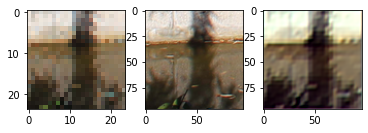

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


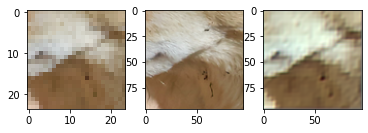

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


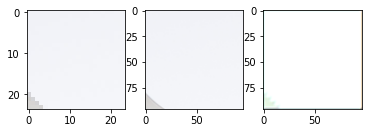

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


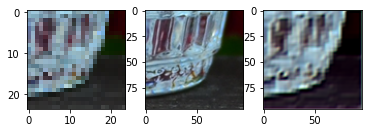

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


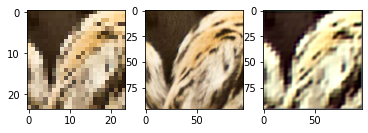

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


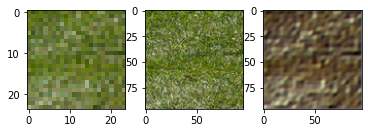

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


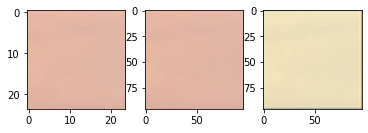

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


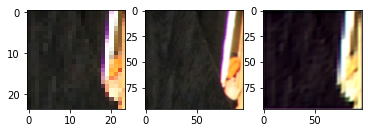

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


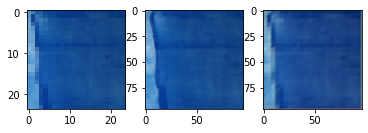

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


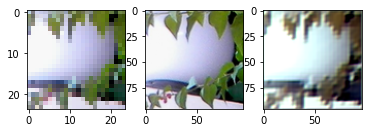

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


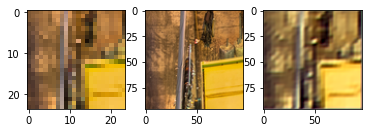

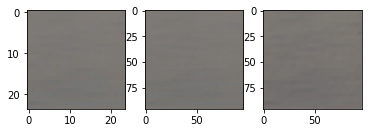

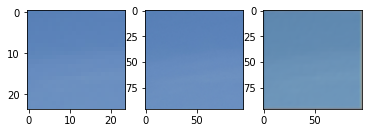

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


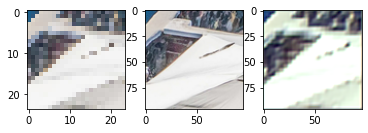

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


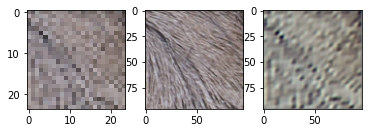

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


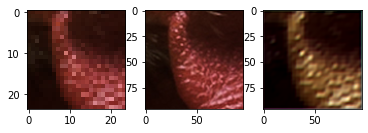

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


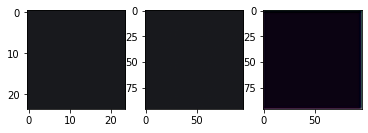

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


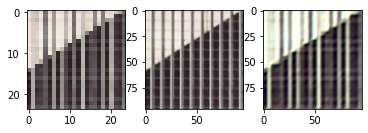

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


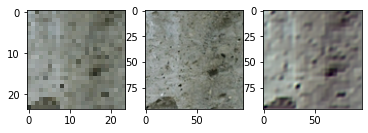

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


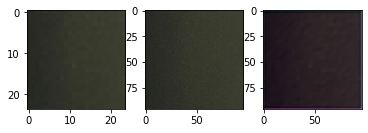

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


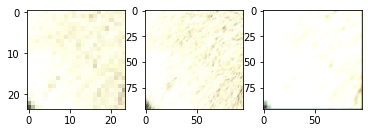

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


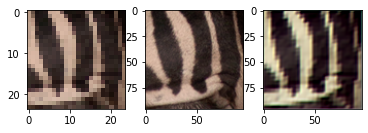

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


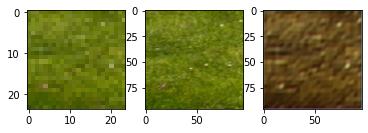

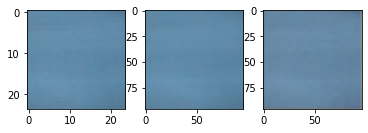

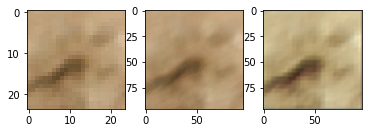

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


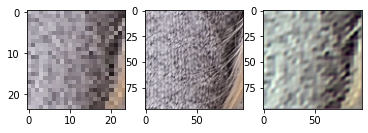

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


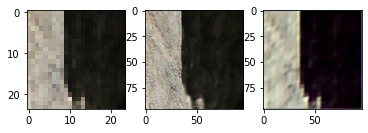

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


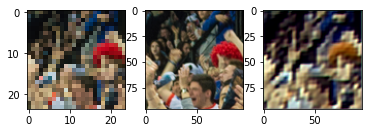

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


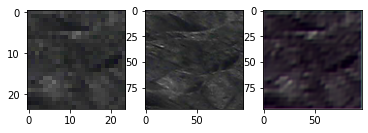

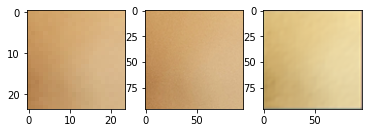

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


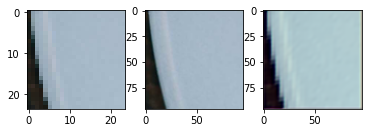

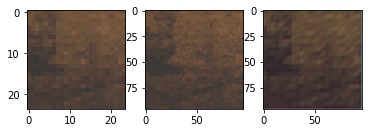

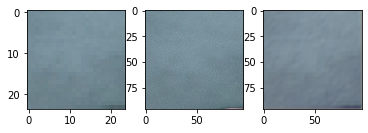

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


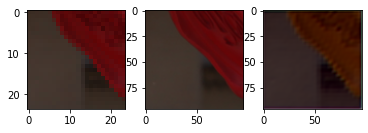

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


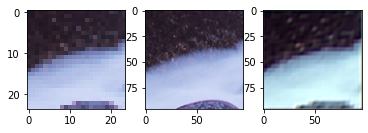

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


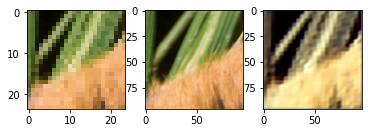

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


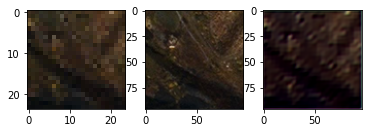

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


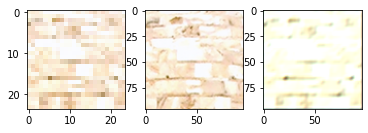

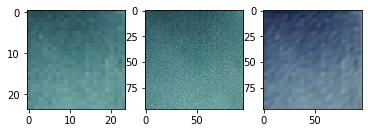

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


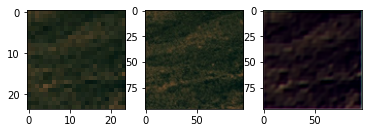

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


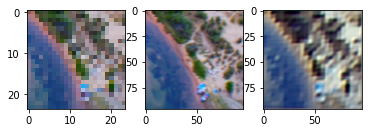

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


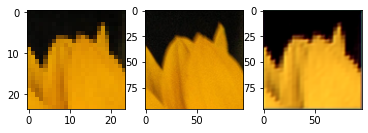

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


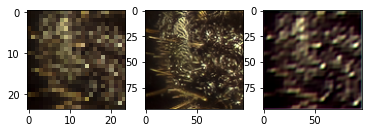

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


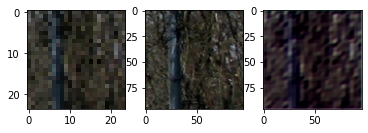

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


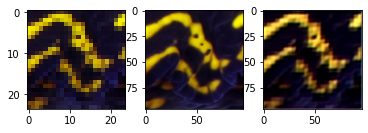

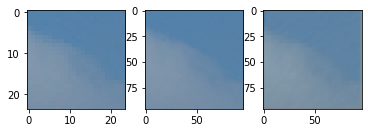

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


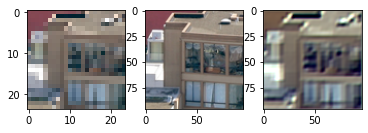

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


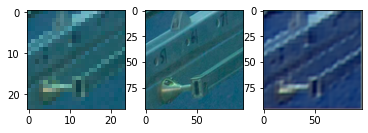

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


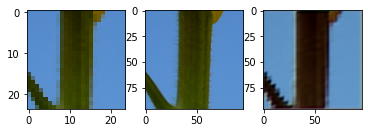

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


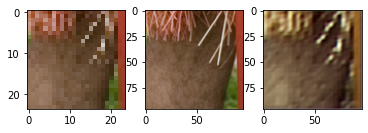

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


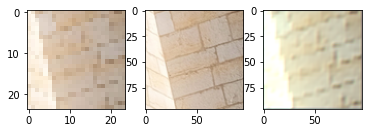

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


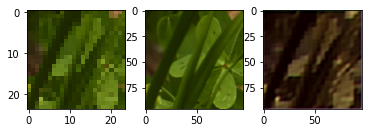

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


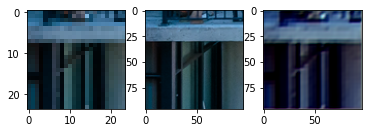

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


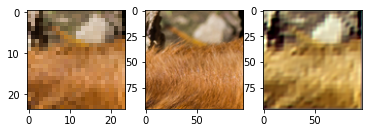

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


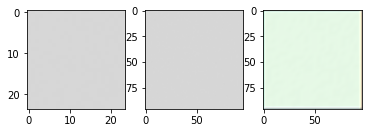

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


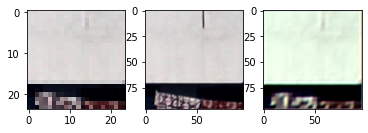

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


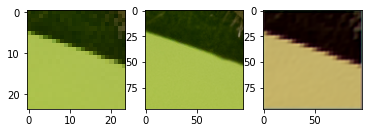

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


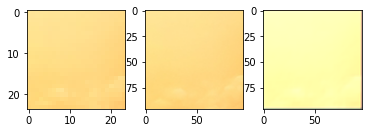

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


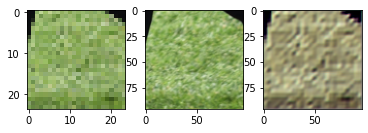

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


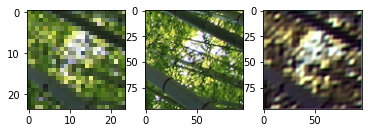

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


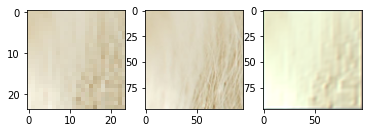

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


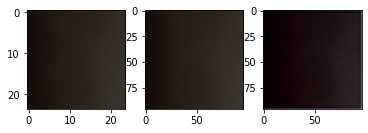

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


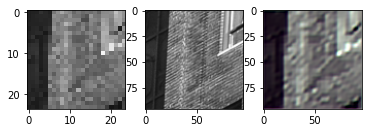

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


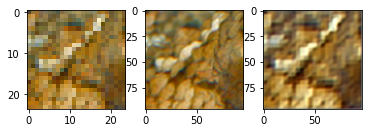

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


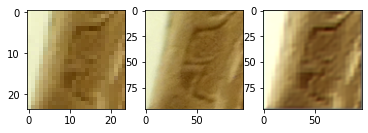

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


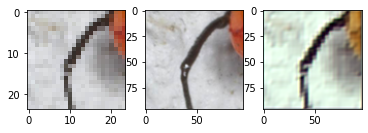

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


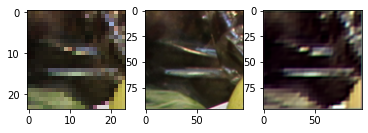

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


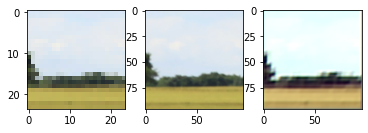

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


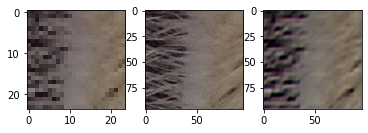

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


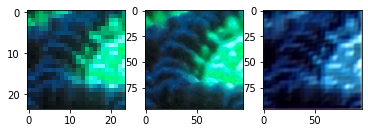

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


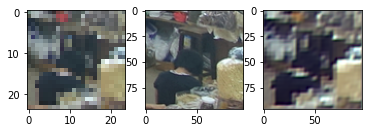

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


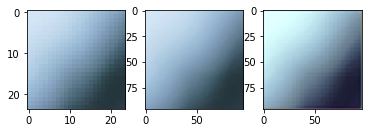

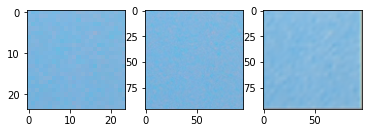

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


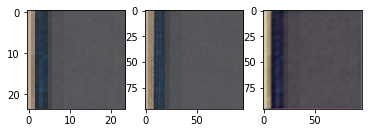

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


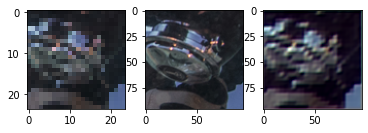

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


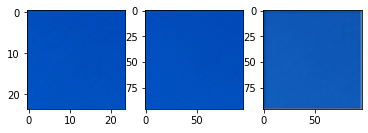

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


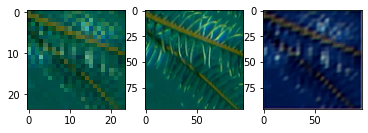

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


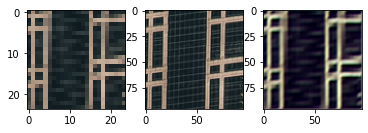

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


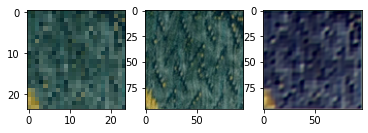

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


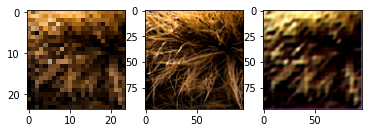

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


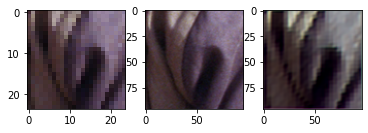

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


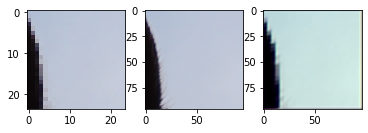

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


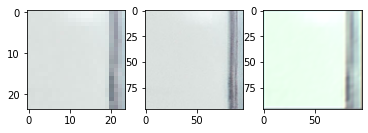

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


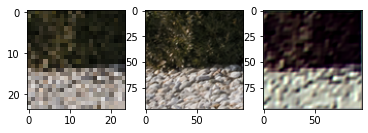

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


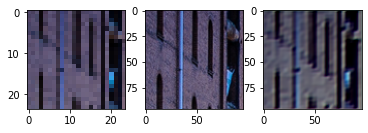

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


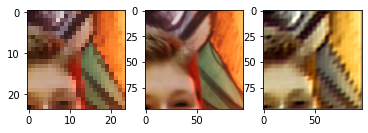

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


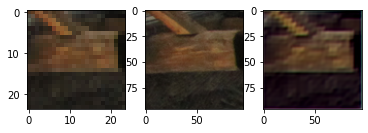

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


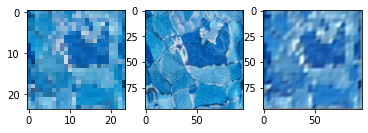

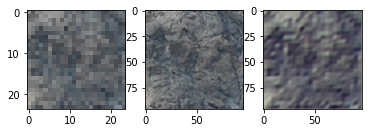

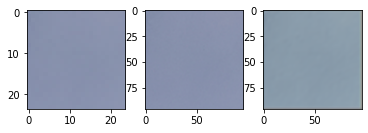

In [39]:
import random
for i in range(70,80):
  generated = generator(train_lr_dataset[10*i:10*i+10])
  for j in range(9):
      plt.subplot(1,3,1)
      plt.imshow(train_lr_dataset[j+10*i]/2+0.5)
      plt.subplot(1,3,2)
      plt.imshow(train_hr_dataset[j+10*i]/2+0.5)
      plt.subplot(1,3,3)
      plt.imshow(generated[j]/2 + 0.5)
      plt.show()

In [ ]:
checkpoint.save(file_prefix = checkpoint_prefix)